# <center><u> ARIMA Models (Core)
* Authored By: Eric N. Valdez
* Date 2/12/2024

## `ARIMA Models Core Assignment`
* Load [this Walmart stock data](https://drive.google.com/file/d/1KKR8TZbkixVN2NundM2mEVv5AhjHhs9a/view).     ([source](https://www.kaggle.com/datasets/meetnagadia/walmart-stock-price-from-19722022))
* We will use data from 2010 to 2020 to predict the Adjusted Close values for the next quarter

## `Imports:`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from datetime import timedelta
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
import itertools

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

## `Load Data:`

In [6]:
# Loading Dataframe
df = pd.read_csv('Data/WMT.csv')
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


In [7]:
# Looking at Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5479 non-null   object 
 1   Adj Close  5284 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.7+ KB


* ### `Make a datetime index using the Date Column with a business day frequency ('B')`

In [8]:
# Make a datetime index using the Date column with a business day frequency ('B')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df = df.asfreq('B')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2000-01-03 to 2020-12-31
Freq: B
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5284 non-null   float64
dtypes: float64(1)
memory usage: 85.6 KB


* ### `Check for and address null values`

In [9]:
# Checking for nulls
df.isnull().sum()

Adj Close    195
dtype: int64

In [10]:
# Filling forward to address null values
df['Adj Close'] = df['Adj Close'].ffill()

In [11]:
# Rechecking my null values
df.isnull().sum()

Adj Close    0
dtype: int64

In [12]:
# Rechecking my Information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2000-01-03 to 2020-12-31
Freq: B
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5479 non-null   float64
dtypes: float64(1)
memory usage: 85.6 KB


In [13]:
# Looking at the first 10 of the dataframe
df.head(10)

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828
2000-01-10,45.209507
2000-01-11,44.537254
2000-01-12,43.738937
2000-01-13,43.780956


* ### `Check the time series for staionarity`
    * Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)

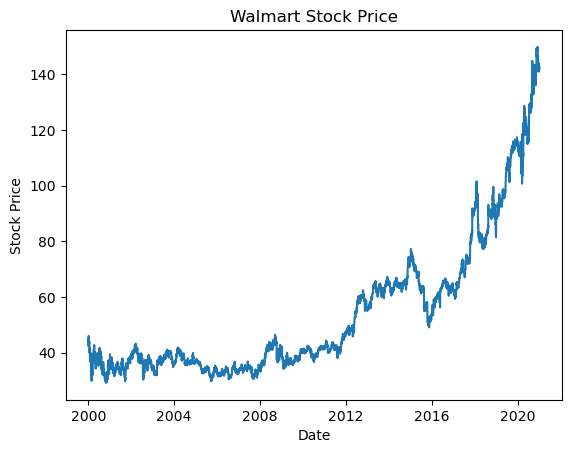

In [14]:
# ploting raw data
plt.plot(df, label='Walmart Stock Price')
plt.title('Walmart Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [15]:
# Testing the raw data for stationarity for ARIMA MODEL
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,2.45764,32,5446,0.999035,0.05,False


In [16]:
# Applying diffenrencing to raw data
d = ndiffs(df)
print(d)

2


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-13.911803,31,5446,0.0,0.05,True


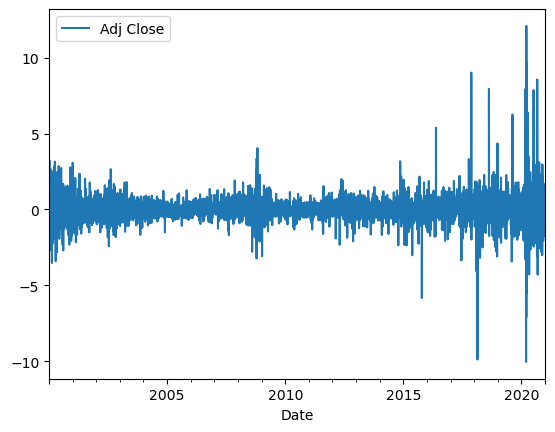

In [17]:
# raw data is not stationary, so we will apply differencing
df_diff2 = df.diff().dropna()
df_diff2.plot()

# Checking for stationarity
get_adfuller_results(df_diff2)

In [18]:
# use ndiffs to determine differencing
d = ndiffs(df)
print(f'd is {d}')

d is 2


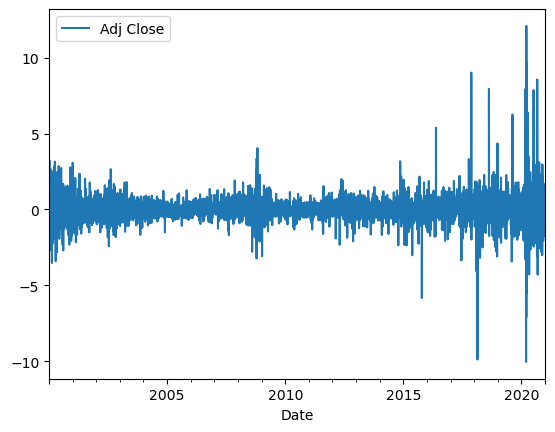

In [19]:
# Plot differenced data
df_diff2.plot();

* ### `Use ACF/PACF plots of the stationary data to estimate initial time series model orders (p, d, q)`

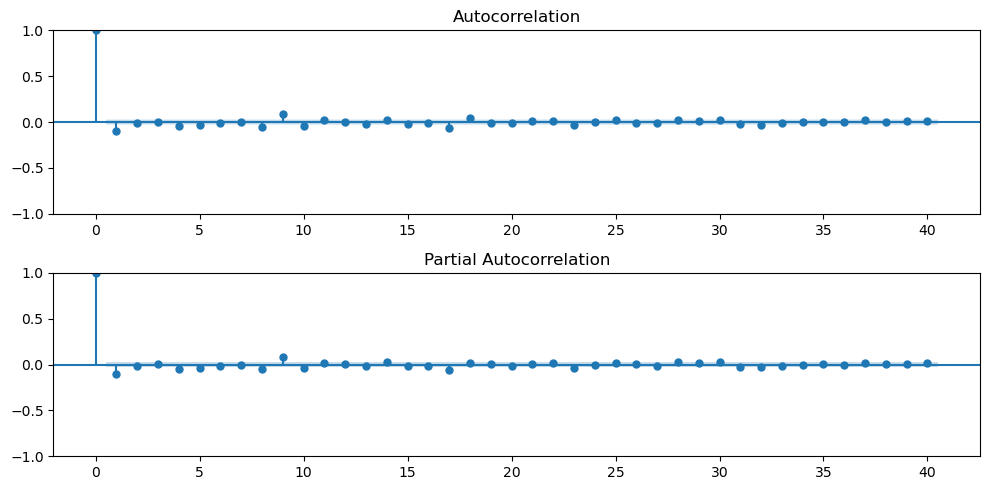

In [20]:
# Use differenced (stationary) data to plot ACF and PACF
plot_acf_pacf(df_diff2);

* ### `Split the time series into training and test data.` <u>Use a test_size of one quarter (13 weeks X 5 business days)

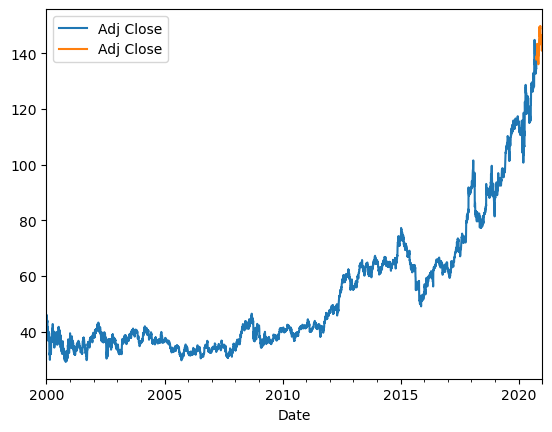

In [50]:
# Calculating number of test lags
# Split the time series into training and test data
n_test_lags = 13*5

# Modeling to predict 6 months into the future
train, test = train_test_split(df, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

* ### `Fit an ARIMA model based on the orders determined during your exploration.`
    * Make forecasts with your model
    * Plot the forecasts versus the test data.
    * Obtain metrics for evaluation.

In [51]:
# Build the model 
p = 0  # AR component 

d = 2  # Number of differencing required to make stationary

q =  1 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 5.364
- MSE = 36.181
- RMSE = 6.015
- R^2 = -4.551
- MAPE = 3.75%


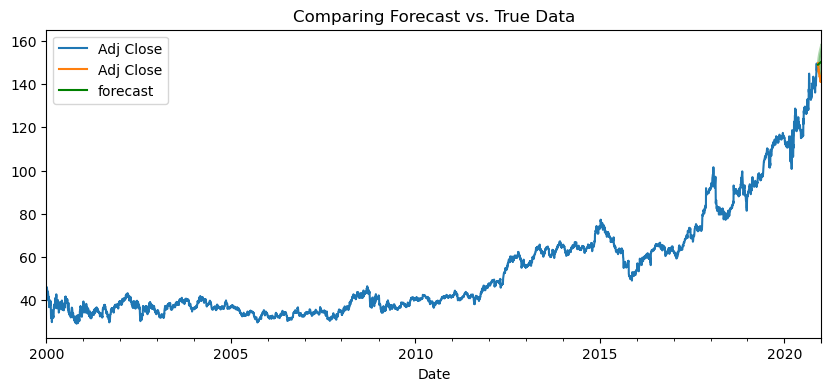

In [42]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [52]:
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5414
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -6682.931
Date:                Tue, 13 Feb 2024   AIC                          13369.863
Time:                        01:22:33   BIC                          13383.056
Sample:                    01-03-2000   HQIC                         13374.468
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.001  -1592.459      0.000      -1.000      -0.998
sigma2         0.6911      0.003    220.357      0.000       0.685       0.697
===================================================================================
Ljung-Box (L1) (Q):                  50.45   Jarque-Bera (JB):            265913.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

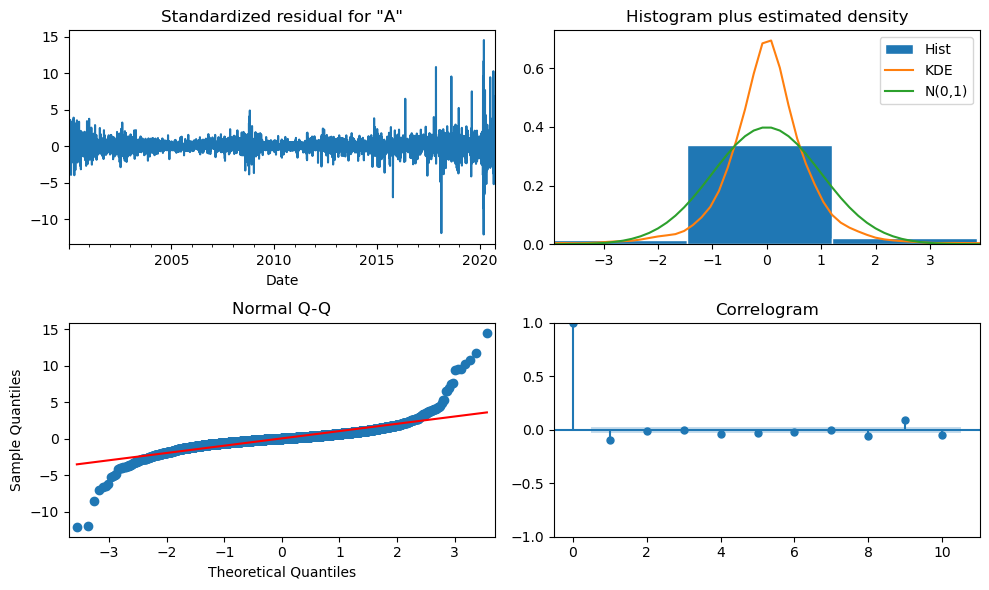

In [53]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

* ### `Try` <u>`at least one variation`</u> `of the model for comparison (we recommend using a loop to try combinations of model orders)`

In [54]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [2]          
q_values = range(0, 3)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [55]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 17599.851772173064
(0, 2, 1) 13369.86282710109
(0, 2, 2) 13319.347175724775
(1, 2, 0) 15737.030328265622
(1, 2, 1) 13321.060555352105
(1, 2, 2) 13373.862431850954
(2, 2, 0) 14997.342386606297
(2, 2, 1) 13320.896147617645
(2, 2, 2) 13315.182874348604
Best AIC: 13315.182874348604
Best pdq: (2, 2, 2)


In [56]:
# Build the model with the best AIC
# Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)
p = 2  # AR component 

d = 2  # Number of differencing required to make stationary

q = 2  # MA component 

# Define and fit the model
tuned_model = tsa.ARIMA(train, order=(p,d,q)).fit()

* ### `A MAPE of less than 2% on hte test data is achievable.`

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.729
- MSE = 12.430
- RMSE = 3.526
- R^2 = 0.033
- MAPE = 1.88%


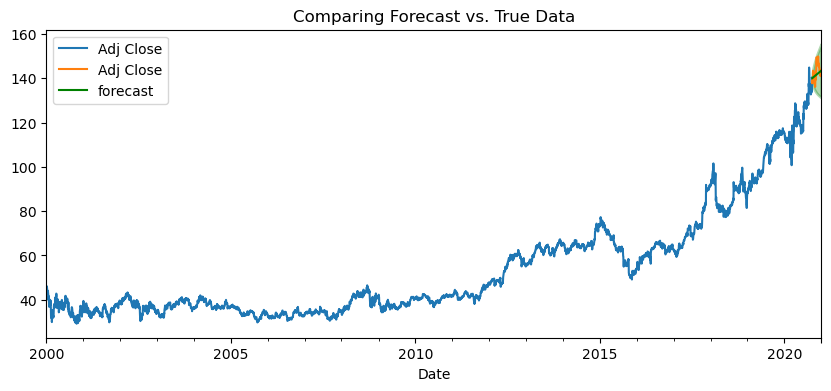

In [57]:
# Obtain summary of forecast as dataframe
forecast_df = tuned_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.720
- MSE = 12.227
- RMSE = 3.497
- R^2 = 0.049
- MAPE = 1.88%


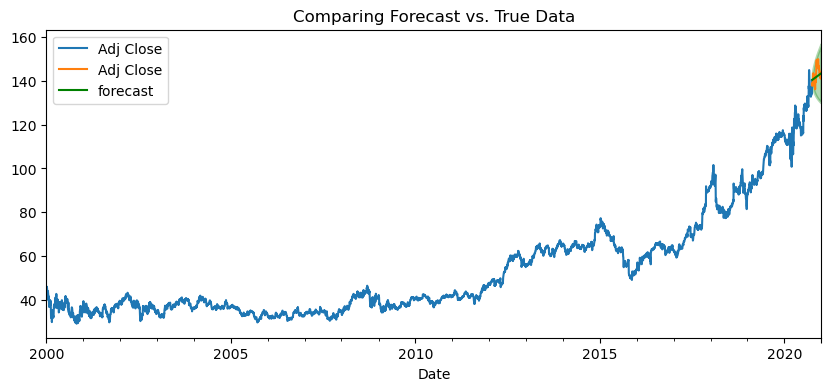

In [58]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

* ### `Choose a final model and explain:`
  * How good was your model, according to your Mean Absolute Percentage Error?
  * How good was your model in terms of how well the forecast seems to follow the test data, visually? ***`(Hint: You may want to plot fewer training data lags to see this)`***

* Actually my model performed better with the parameters (6, 2, 3) for p, d, q; I got a MAPE of 1.88 (0, 2, 0 got it 1.78 but the numbers were extremely high for MAE, MSE, RMSE, & R^2) the parameters I uses in this last model lowered them by a larger margin.
* It seems to follow with a straight line going through the actual data as far as I can see.